## On the Job Search Insurance

### Carlos Lizama, Benjamín Villena

#### Brief summary of the model
* On-the-job search model. Each workers has an idiosyncratic process $x$ which determines the probability of being fired each period. The process has some persistance.
* If the worker switch jobs, the underlying variable $x$ starts from its steady state value.
* Wages are drawn from an exogneous distribution.
* Job finding probability $p(s)$ depends on effort $s$.
* There is no self-insurance, ie, agents can not save nor borrow.

#### Equations

The value on unemployment is determined by

$$(1-\beta) U = u(b) - \lambda s^* + \beta p(s) \int_{w^*}^{\bar{w}} (W(w, \bar{x}) - U) dF(w)$$

where $w^*$ is the reservation wage $W(w^*, \bar{x}) = U$ and $s^*$ is determined by
$$\lambda = \beta p'(s) \int_{w^*}^{\bar{w}} (W(w, \bar{x}) - U) dF(w)$$

The value of employement, state $(w,x)$ is

$$W(w,x) = u(w) - \lambda s^* + \beta \left\{ p(s) \left[ \int_{w^*(w,x)}^{\bar{w}} \left( W(w',ar{x}) - \int W(w,x') dG(x'|x) \right) dF(w') +\delta(x) \left( \int W(w,x') dG(x'|x) - U \right)  \right] + \delta(x) U + (1-\delta(x)) \int W(w,x') dG(x'|x) \right\}$$

where $w^*(w,x)$ is such that $W(w^*(w,x),ar{x}) = \int W(w,x') dG(x'|x)$ and $s^*(w,x)$ is determined by
$$\lambda = \beta p'(s) \left\{ \int_{w^(w,x)}^{\bar{w}} \left( W(w',x) - W(w,x') dG(x'|x) \right) dF(w') + \delta(x) \left( \int W(w,x') dG(x'|x) - U \right) \right\}$$

Note that the new job starts with a value of match quality $ar{x}$.
#### Functional forms
Need to set functional forms to $u(c), F(w), p(s), G(x'|x), \delta(x)$

* $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$, with $\sigma = 2$
* $F(w)$ is truncated Pareto
* $p(s)$ is exponential.
* $G(x'|x)$: x follows and AR(1), discretized.
* $\delta(x)$ is normal. 

Of course, all of these parametrization can be changed. 

The choice of utility function is standard in the literature.

I chose truncated Pareto since wages the data follow approximately a Pareto distribution. Another possibility is to change it by a log-normal. The code is made in such a way that this kind of changes are easy to make.

The exponential function for the job finding probability is to consider decreasing returns to effort and effort to be defined from 0 to infinity.

AR(1) for x just to make it a Markov process and easy to discretize.

#### Parameters
Need to set values for discount factor $\beta$, persistence of idiosyncratic process $\rho$, effort cost $\lambda$, unemployment benefits $b$


In [18]:
## Import Packages
using Distributions
using Roots
using PyPlot
using Interpolations

I define a couple of functions that I will use throughout the code.

In [19]:
"""
Rowenhorst method for approximating AR(1) processes, z_{t+1} = (1-ρ)μ + ρ z_t + ɛ, where ɛ ∼ N(0,σ²)

Inputs 
μ: unconditional mean of the process
ρ: persistence of the process
σ: standard deviation of innovations
N: number of gridpoints 

Output
z: gridpoints, points where the discrete version of the AR(1) takes values, dim = N
P: transition matrix between states, dim NxN

"""
function Rouwenhorst(μ, ρ, σ, N)
    
    # grid points
    σz = sqrt(σ^2/(1-ρ^2)) 
    ψ = σz*sqrt(N-1)
    z = μ + collect(linspace(-ψ,ψ,N))
    
    # transition matrix
    p = (1+ρ)/2
    q = (1+ρ)/2
    
    P = [p 1-p; 1-q q]
    
    for n=3:N
        v0 = zeros(n-1,1)
        P = p*[P v0; v0' 0] + (1-p)*[v0 P; 0 v0'] +(1-q)*[v0' 0; P v0] + q*[0 v0'; v0 P];
        P[2:end-1,:] = P[2:end-1,:]/2;
    end
     
    return z,P
    
end

Rouwenhorst (generic function with 1 method)

In [20]:
"""
Trapezoidal method  for computing integrals. This method also works for non-uniform grids.
∫ₐᵇ f(x) dx = 1/2 ∑ (x_{k+1}-x_{k}) (f(x_{k+1}) + f(x_k))
"""
function Trapezoidal(x,f)
    
    I = (x[2:end]-x[1:end-1])'*(f[2:end]+f[1:end-1])/2
    
    return I[1]
end


Trapezoidal (generic function with 1 method)

In [21]:
## Paramtrization/Calibration

# Parameter
β = 0.95    # discount factor
ρ = 0.75    # persistence of AR(1) process
λ = 1       # marginal cost of effort
b = 20.      # unemployment benefits
σ = 2.       # risk aversion
σₑ = .01      # std of innovations in AR(1) process
Nx = 11     # number of points in the discretized process of x. Odd number so the middle point is on the grid.
n0 = Int(ceil(Nx/2))   # index of middle x.
Nw = 20     # number of gridpoints in grid for w.

u(x) = x.^(1-σ)/(1-σ)  # utility function
w₋ = 10.                # lower limit of wage distribution
w⁻ = 100.              # upper limit of wage distribution
w = w₋ + (w⁻-w₋)*linspace(0,1,Nw).^2    # w grid. .^2 is to make a non-uniform grid to capture 
                                        # more curvature at the beginnning of the grid 

Ub = u(b)
Uw = u(repmat(w,1,Nx))   # utility of consuming w in each state (w,x).

# define F
α = 1.01                 # parameter of Pareto distribution
F₀ = Pareto(α, w₋)
F₁ = Truncated(F₀, w₋, w⁻)   # truncate Pareto.
F = pdf(F₁, w)
sumF = Trapezoidal(w, F)
F = F/sumF             # discretization of wage distribution, measure over each gridpoint of w.

# define p, p(s) is job finding rate depending on effort. For this case, p is an exponential distribution.
θₑ = 0.01                # parameter of exponential distribution. In Julia this parameter equals the mean.
pdist = Exponential(θₑ)
p(s) = pdf(pdist, s) 
P(s) = cdf(pdist, s)

# Discretize AR(1) process.
δ = Normal()                   # define δ
q = quantile(δ,.02)
x, Px = Rouwenhorst(q, ρ, σₑ, Nx)   # x underlying process of dismissal, Px transition matrix
δₓ = cdf(δ,x)                  # δ(x) probability of being dismissed.
δX = repmat(δₓ',Nw,1)          # δ(x) as a matrix, I will use it, it is usefull to vectorize calculations.

## Initial guess
U = Ub
W = Uw
S = 0.01*ones(Nw,Nx) # optimal effort for employed workers
s0 = 0.01
Sp = zeros(Nw,Nx)
W0 = zeros(Nw,Nx)   # reservation wages for employed workers
Ex = zeros(Nw,Nx)   # Expected value condition on x, E[W(w,x')|x]
I1 = zeros(Nw,Nx)   # integral in optimal effort for unemployed  
I = zeros(Nw,Nx)    # integral in optimal effort for employed

ii=0 # used for debugging
jj=0

0

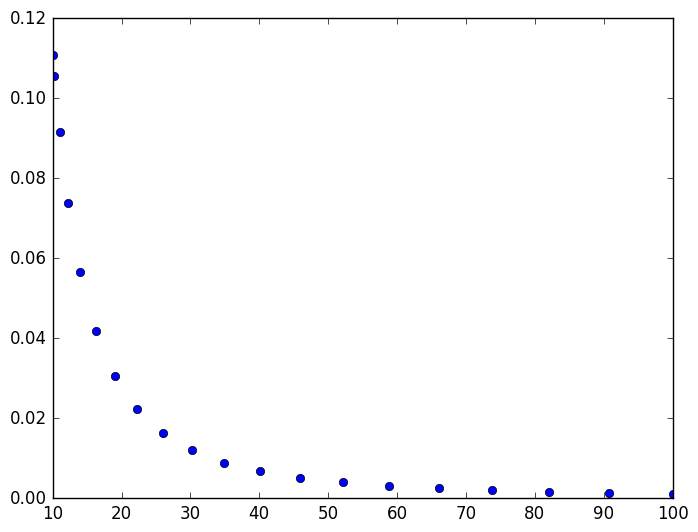

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31c476860>

In [22]:
# Show distribution of wages
plot(w,F,"o")


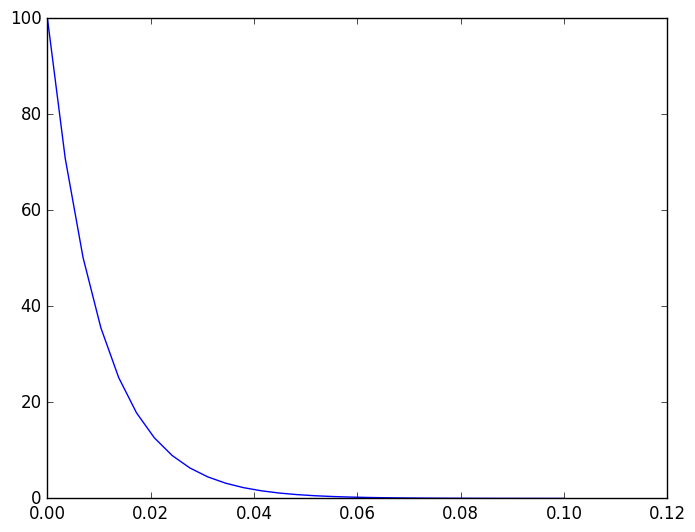

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31c68d550>

In [23]:
# job finding probability given effort s
plot(linspace(0,.1,30), p(linspace(0,.1,30)))

In [24]:
## Algorithm: Value function Iteration

ɛ = 1e-8
#T = 300   
iter=0
Δ=1

@time while Δ >= ɛ
    
    iter+=1 
    
    # optimal effort for unemployed worker
    I0 = Trapezoidal(w, (max(W[:,n0]-U,0).*F))
    
    # check corner solution
    if λ > β*p(0)*I0
        s0p = 0
    else    
        f(s) = λ/(β*I0)- p(s)
        s0p = fzero(f, [0, 1])
    end
        
    # optimal effort for employed worker
    for i=1:Nw
        ii=ii+1
        for j=1:Nx
            jj=jj+1
            Ex[i,j] = (W[i,:]*Px[j,:]')[1]
            I1[i,j] = Trapezoidal(w, (max(W[:,j]-Ex[i,j],0).*F))
            I[i,j] = I1[i,j] + δₓ[j]*(Ex[i,j]-U)
            
            # check corner solution
            if λ > β*p(0)*I[i,j]
                Sp[i,j] = 0
            else
                f(s) = λ/(β*I[i,j])- p(s)
                Sp[i,j] = fzero(f, [0, 1])
            end
        end
        jj=0
    end

    # Update guess for U and W
    Up = (Ub - λ*s0p + β*P(s0p)*I0) + β*U
    Wp = Uw -λ*Sp + β*(P(Sp).*I + δX*U + (1-δX).*Ex)

    Δ = max(vecnorm(W-Wp,2),abs(U-Up))  # not sure which norm is best, but it shouldn't make much difference.
    
    U = Up
    W = copy(Wp)
    s0 = s0p
    S = copy(Sp)
    
#    println(Δ)
    
end


  2.039071 seconds (31.80 M allocations: 728.738 MB, 4.27% gc time)


In [25]:
W

20x11 Array{Float64,2}:
 -0.710263  -0.710387  -0.710512  …  -0.711271  -0.7114    -0.711529
 -0.707531  -0.707654  -0.707778     -0.708531  -0.708658  -0.708786
 -0.699639  -0.69976   -0.699883     -0.700621  -0.700744  -0.700869
 -0.687374  -0.687492  -0.687611     -0.688328  -0.688447  -0.688568
 -0.671718  -0.671831  -0.671946     -0.672637  -0.672752  -0.672869
 -0.653578  -0.653687  -0.653797  …  -0.654462  -0.654574  -0.654686
 -0.63364   -0.633745  -0.633852     -0.634495  -0.634603  -0.634712
 -0.612327  -0.612429  -0.612533     -0.613162  -0.613268  -0.613375
 -0.589814  -0.589916  -0.590019     -0.590647  -0.590753  -0.59086 
 -0.566056  -0.566162  -0.566268     -0.566918  -0.567028  -0.56714 
 -0.540798  -0.540912  -0.541028  …  -0.541739  -0.54186   -0.541983
 -0.513539  -0.513673  -0.513809     -0.514649  -0.514793  -0.514939
 -0.483443  -0.483618  -0.483794     -0.484889  -0.485078  -0.485268
 -0.449365  -0.449609  -0.449856     -0.451397  -0.451664  -0.451934
 -0.417354

### Plot results

#### Value function

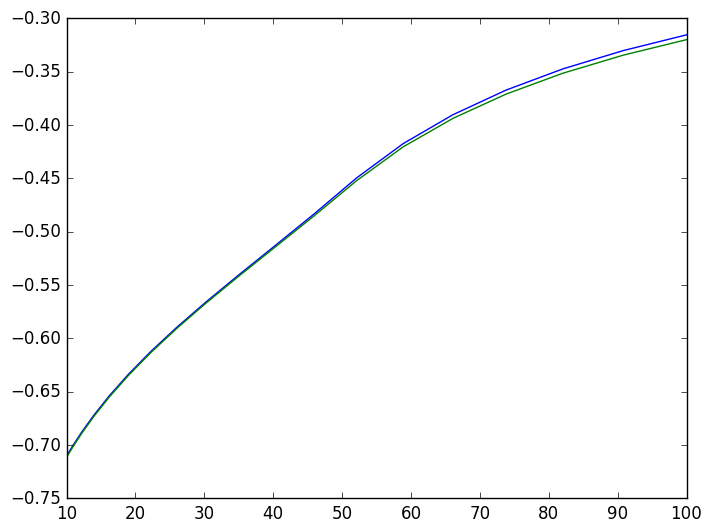

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31ca142b0>
 PyObject <matplotlib.lines.Line2D object at 0x31ca14cc0>

In [26]:
plot(w, W[:,1], w, W[:,end])

x-axis wage, y-axis value function W[w,:]. This graph shows that the value of employment is increasing in wage. It is also decreasing in x (blue line x=x[1] and green line x=x[end]). I plot only for two values of $x$ since all of them are very close.

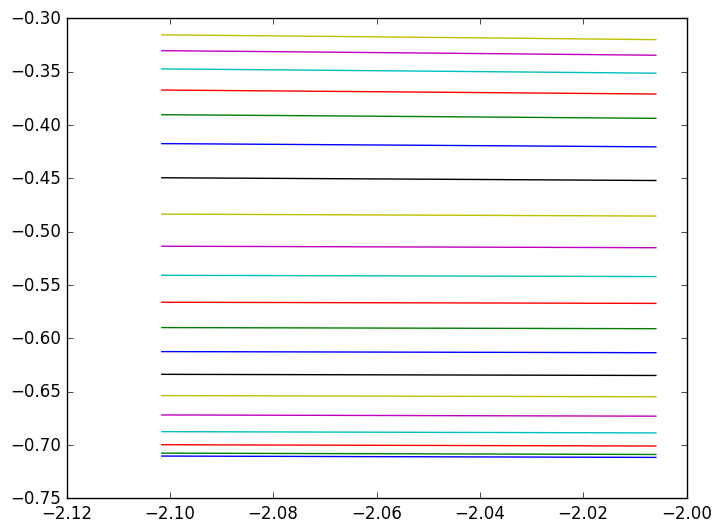

20-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31cca3748>
 PyObject <matplotlib.lines.Line2D object at 0x31cca38d0>
 PyObject <matplotlib.lines.Line2D object at 0x31cca3b70>
 PyObject <matplotlib.lines.Line2D object at 0x31cca3d68>
 PyObject <matplotlib.lines.Line2D object at 0x31cca3f60>
 PyObject <matplotlib.lines.Line2D object at 0x31cca8198>
 PyObject <matplotlib.lines.Line2D object at 0x31cca8390>
 PyObject <matplotlib.lines.Line2D object at 0x31ca52c88>
 PyObject <matplotlib.lines.Line2D object at 0x31cca8780>
 PyObject <matplotlib.lines.Line2D object at 0x31cca8978>
 PyObject <matplotlib.lines.Line2D object at 0x31cca8b70>
 PyObject <matplotlib.lines.Line2D object at 0x31cca8d68>
 PyObject <matplotlib.lines.Line2D object at 0x31cca8f60>
 PyObject <matplotlib.lines.Line2D object at 0x31ccac198>
 PyObject <matplotlib.lines.Line2D object at 0x31cca8588>
 PyObject <matplotlib.lines.Line2D object at 0x31ccac588>
 PyObject <matplotlib.lines.Line2D object at 0x

In [27]:
plot(x, W')

x-axis value of idiosyncratic shock $x$, y-axis value W[:,x], each line corresponds to a different value of $w$. This graph shows that the value of being employed is decreasing in x and it is incrasing in w (blue line w=w[1], green line w=w[2], ...)

#### Policy function

In [28]:
S

20x11 Array{Float64,2}:
 0.0225988   0.0225907   0.0225823   …  0.0225295   0.0225202   0.0225107 
 0.0223327   0.0223244   0.022316       0.0222627   0.0222533   0.0222438 
 0.0215673   0.0215588   0.0215501      0.0214953   0.0214857   0.0214759 
 0.0203871   0.0203782   0.0203692      0.0203123   0.0203024   0.0202923 
 0.0188964   0.0188872   0.0188778      0.018819    0.0188087   0.0187983 
 0.0171903   0.0171809   0.0171713   …  0.0171113   0.0171009   0.0170903 
 0.01534     0.0153306   0.0153211      0.015262    0.0152518   0.0152415 
 0.0133896   0.0133809   0.0133721      0.0133174   0.013308    0.0132985 
 0.0113594   0.0113522   0.0113448      0.0113005   0.011293    0.0112855 
 0.00924866  0.00924436  0.00924005     0.00921548  0.00921163  0.00920776
 0.00703796  0.00703896  0.00704006  …  0.00705075  0.00705325  0.00705588
 0.00468676  0.00469709  0.0047077      0.00477966  0.00479309  0.00480685
 0.00212587  0.00215286  0.00218035     0.00235952  0.0023918   0.00242464
 

In [29]:
s0

0.014660377638158875

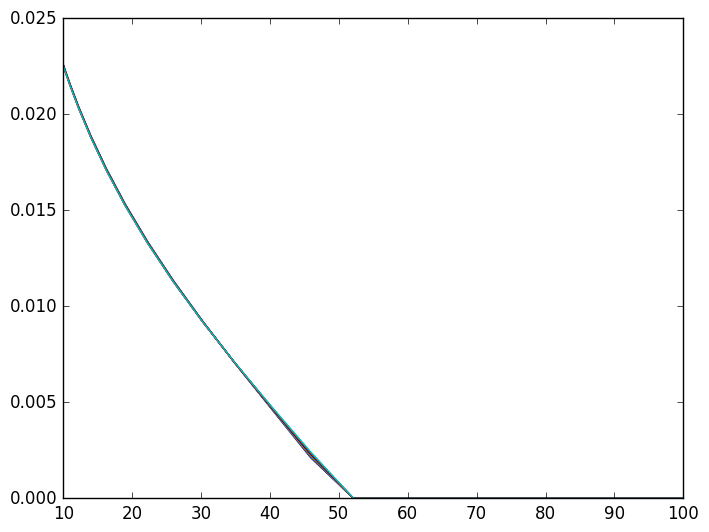

11-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31cec5898>
 PyObject <matplotlib.lines.Line2D object at 0x31cec5a20>
 PyObject <matplotlib.lines.Line2D object at 0x31cec5cc0>
 PyObject <matplotlib.lines.Line2D object at 0x31cec5eb8>
 PyObject <matplotlib.lines.Line2D object at 0x31ceca0f0>
 PyObject <matplotlib.lines.Line2D object at 0x31ceca2e8>
 PyObject <matplotlib.lines.Line2D object at 0x31ceca4e0>
 PyObject <matplotlib.lines.Line2D object at 0x31cd19710>
 PyObject <matplotlib.lines.Line2D object at 0x31ceca8d0>
 PyObject <matplotlib.lines.Line2D object at 0x31cecaac8>
 PyObject <matplotlib.lines.Line2D object at 0x31cecacc0>

In [30]:
plot(w,S)

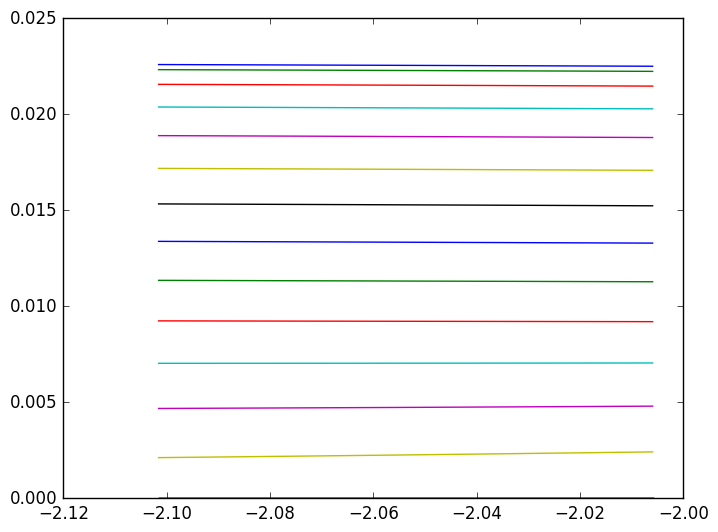

20-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d0be9b0>
 PyObject <matplotlib.lines.Line2D object at 0x31d0beb38>
 PyObject <matplotlib.lines.Line2D object at 0x31d0bedd8>
 PyObject <matplotlib.lines.Line2D object at 0x31d0befd0>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c3208>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c3400>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c35f8>
 PyObject <matplotlib.lines.Line2D object at 0x31cf1de48>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c39e8>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c3be0>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c3dd8>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c3fd0>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c7208>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c7400>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c37f0>
 PyObject <matplotlib.lines.Line2D object at 0x31d0c77f0>
 PyObject <matplotlib.lines.Line2D object at 0x

In [31]:
plot(x,S')

In general, S is decreasing in wages and increasing in x.

The higher the wage, the lower the effort made by the worker. When the worker receives a high wage, the probability of getting a better wage is low and thus the marginal benefit of exerting effort is low. Hence, the worker does not make much effort finding a better job. Furthermore, when the wages are high enough, the worker stop looking for a job altogether. 

The higher the $x$, the higher the probability of being fired in this periods and in the following periods, because of the persistence of the process. The probability of being fired today carries information about the likelihood of being fired in the future, so the higher the probability of being fired today, the higher are the incentives to look for another job.

### Reservation wages

For the unemployed worker, the reservation wage is given by
$$ W(w^*,\bar{x}) = U $$

and for the employed worker
$$ W(w^*(w,x), \bar{x}) = \int W(w,x') dG(x'|x) = E_x[W(w,x')|x] $$

In order to solve for these equations, I interpolate the function $W(w,\bar{x})$

In [32]:
# reservation wage of unemployed worker

W_int = interpolate((w,), W[:,n0], Gridded(Linear()))

# reservation wage for unemployed worker
f(x) = W_int[x]-U 
w0 = fzero(f,[w₋,w⁻])    

# reservation wage for employed workers 
# (only defined when the worker exert effort, otherwise it is set to the current wage, just to avoid NaN)
for i=1:Nw
    for j=1:Nx
        if S[i,j]==0
            W0[i,j] = w[i]
        else
            f(x) = W_int[x]-Ex[i,j]
            W0[i,j] = fzero(f,w[i])
        end
    end
end


In [33]:
W0

20x11 Array{Float64,2}:
  10.0431   10.0346   10.026    10.0174  …    9.97406    9.96534    9.95657
  10.2939   10.285    10.2762   10.2673      10.2237    10.2151    10.2064 
  11.0443   11.0349   11.0256   11.0162      10.9713    10.9625    10.9538 
  12.2939   12.284    12.274    12.2639      12.2168    12.2077    12.1986 
  14.0426   14.0319   14.0212   14.0105      13.9604    13.9508    13.9412 
  16.29     16.2787   16.2672   16.2558  …   16.2021    16.1918    16.1815 
  19.0362   19.0241   19.0119   18.9997      18.9421    18.931     18.9199 
  22.2812   22.2683   22.2553   22.2423      22.1803    22.1683    22.1562 
  26.0253   26.0115   25.9977   25.9837      25.9165    25.9033    25.8901 
  30.2695   30.2545   30.2395   30.2244      30.1502    30.1354    30.1206 
  35.0152   34.9985   34.9817   34.9648  …   34.8802    34.8632    34.8461 
  40.2652   40.2457   40.226    40.2062      40.1048    40.0841    40.0632 
  46.0244   45.9999   45.9753   45.9504      45.8205    45.7936 

Next, I compute the difference between the reservation wages and the current wage

In [34]:
W0-repmat(w,1,Nx)

20x11 Array{Float64,2}:
 0.0430984  0.0345635  0.0259806  …  -0.0259392  -0.0346623  -0.0434329
 0.0445634  0.0357368  0.0268618     -0.0256084  -0.0342187  -0.0428745
 0.0470363  0.0377159  0.0283463     -0.0259635  -0.0346893  -0.0434589
 0.0501437  0.0402021  0.0302106     -0.0269734  -0.0360336  -0.045137 
 0.0536436  0.0430033  0.0323117     -0.0285487  -0.0381338  -0.0477627
 0.0573395  0.0459637  0.0345343  …  -0.0305779  -0.0408423  -0.0511531
 0.061135   0.0490076  0.0368224     -0.0329813  -0.0440538  -0.0551774
 0.0651125  0.0522019  0.039227      -0.0357799  -0.0477976  -0.0598738
 0.0696499  0.0558508  0.0419773     -0.0391875  -0.0523605  -0.0656034
 0.0755916  0.0606327  0.045584      -0.0437421  -0.0584629  -0.0732711
 0.084497   0.0677987  0.050988   …  -0.0505059  -0.0675251  -0.0846576
 0.0990207  0.0794754  0.0597862     -0.0613895  -0.0820983  -0.102957 
 0.124165   0.0996601  0.0749736     -0.079735   -0.106634   -0.133726 
 0.0        0.0        0.0            0.

As expected, the difference is possitive for low values of $x$ and negative for high values of $x$. This means that workers are willing to accept a lower wage in a new job to avoid being fired in their current job. When the probability of being fired is low, workers move only if the wage is high enough. 